# KNN model for predicting racket type using datasets P1, P2, and P3, based on **envelope** - Vibration

### Model Description

This notebook implements a K-Nearest Neighbors (KNN) model to predict the type of a racket (RV, RR, RB) based on sound features extracted from vibration datasets. The workflow involves reading `.csv` files, **envelope** using FFT, and training the model using these features.

### Import libraries

In [1]:
import os
import glob
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.io import wavfile
from scipy.fft import fft
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.signal import find_peaks
import librosa
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
# import openpyxl

### Import Tools Functions

In [2]:
import sys
# Reach the project root
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '../../../'))
functions_path = os.path.join(project_root, 'Functions')

# Add Functions folder
if functions_path not in sys.path:
    sys.path.append(functions_path)

Energy

In [3]:
from envelope_from_signal import envelope_from_signal

# Main

In [4]:
import ast

# Read the CSV file
df_combined = pd.read_csv("../../../Data/Vibration/All_Data_combinedv3.csv")


df_combined.head()

,Raw Signal Ch0,Spectrum,freqs,File Name,Position,Racket Type,Age
0,[-0.01573961 -0.02470204 -0.0184555 ... -6.36...,"[5415.435319490299, 3187.673624625387, 2567.48...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_C_1.csv,C,RB,1
1,[ 0.10185837 0.10090781 0.08882211 ... -6.35...,"[3574.0039456266313, 2253.172677296551, 2189.4...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_C_2.csv,C,RB,1
2,[-0.02701054 -0.01506063 -0.02510942 ... -6.09...,"[4336.317505980091, 2636.183071505374, 2297.29...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_C_3.csv,C,RB,1
3,[-0.05687327 -0.06352719 -0.05049093 ... -9.29...,"[7218.047965980523, 4371.60331681831, 3234.473...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_S_1.csv,S,RB,1
4,[-0.08674804 -0.04994775 -0.05334261 ... -8.81...,"[6351.72555524914, 3431.4594161592727, 3006.71...","[158.33333333333331, 166.66666666666663, 174.9...",P1_RB_1_S_2.csv,S,RB,1


In [5]:
# Compute the feature
freqs = np.array(ast.literal_eval(df_combined["freqs"].iloc[0]))  # Convert string to numpy array

envelope_list=[]

for spectrum in df_combined["Spectrum"]:
    spectrum_list = np.array(ast.literal_eval(spectrum))  
    envelope = envelope_from_signal(spectrum_list)
    envelope_list.append(envelope)



df_combined["envelope"]=envelope_list


In [6]:
# Determine the minimum number of samples for each age group
min_samples_per_age = df_combined['Racket Type'].value_counts().min()

# Create a new DataFrame with equal samples for each age group
df_sorted_homogeneous = (
    df_combined.groupby('Racket Type')
    .apply(lambda x: x.sample(n=min_samples_per_age, random_state=42))
    .reset_index(drop=True)
)

df_sorted_homogeneous

# Verify the distribution
print(df_sorted_homogeneous['Racket Type'].value_counts())




X = np.array(df_sorted_homogeneous["envelope"].tolist())

# Encode string labels into integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_sorted_homogeneous["Racket Type"])


# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




Racket Type
RB    188
RO    188
RR    188
RV    188
Name: count, dtype: int64


C:\Users\Abdelaziz\AppData\Local\Temp\ipykernel_23804\3619777348.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_samples_per_age, random_state=42))


In [7]:
# Définir les bonnes valeurs trouvé
n_neighbors = 10  # Nombre de voisins
weights_options = ['uniform']  # Méthode de pondération
metric_options = ['manhattan']  # Métriques


# Définir les plages de valeurs pour les hyperparamètres
n_neighbors_range = range(1, 21)  # Nombre de voisins
weights_options = ['uniform', 'distance']  # Méthode de pondération
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']  # Métriques

# Liste pour stocker les résultats
results = []


# Tester toutes les combinaisons d'hyperparamètres
for n_neighbors in n_neighbors_range:
    for weights in weights_options:
        for metric in metric_options:
            # Créer et entraîner le modèle KNN
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
            knn.fit(X_train, y_train)

            # Évaluer sur l'ensemble de test
            y_pred = knn.predict(X_test)
            accuracy_test = accuracy_score(y_test, y_pred)

            # Évaluer sur l'ensemble d'entraînement
            y_train_pred = knn.predict(X_train)
            accuracy_train = accuracy_score(y_train, y_train_pred)

            # Ajouter les résultats à la liste
            results.append({
                'n_neighbors': n_neighbors,
                'weights': weights,
                'metric': metric,
                'accuracy_train': accuracy_train,
                'accuracy_test': accuracy_test
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)



print(results_df)

     n_neighbors   weights     metric  accuracy_train  accuracy_test
0              1   uniform  euclidean        1.000000       0.986755
1              1   uniform  manhattan        1.000000       1.000000
2              1   uniform  chebyshev        1.000000       0.993377
3              1   uniform  minkowski        1.000000       0.986755
4              1  distance  euclidean        1.000000       0.986755
..           ...       ...        ...             ...            ...
155           20   uniform  minkowski        0.986689       0.966887
156           20  distance  euclidean        1.000000       1.000000
157           20  distance  manhattan        1.000000       0.986755
158           20  distance  chebyshev        1.000000       0.973510
159           20  distance  minkowski        1.000000       1.000000

[160 rows x 5 columns]


## Results and Visualisation

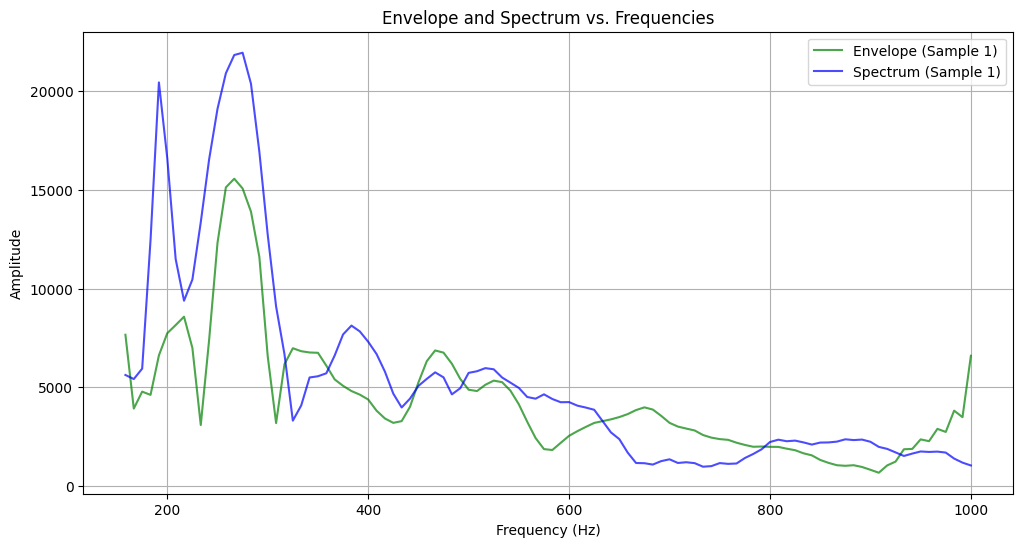

In [8]:
# Plot the envelope and spectrum against the frequencies
plt.figure(figsize=(12, 6))

# Plot the envelope
plt.plot(freqs, envelope_list[0], label="Envelope (Sample 1)", color="green", alpha=0.7)

# Plot the spectrum
plt.plot(freqs, spectrum_list, label="Spectrum (Sample 1)", color="blue", alpha=0.7)

plt.title("Envelope and Spectrum vs. Frequencies")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()
